In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

#### helper functions

In [2]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [3]:
def add_species(df, species):
    df['Species'] = species
    return df

In [4]:
def filter_cleanups(df, cleanups):
    return df[df.cleanup.isin(cleanups)]

In [5]:
def clean_df(df, species, cleanups):
    df = convert_seg_error_rate_pct(df)
    df = add_species(df, species)
    df = filter_cleanups(df, cleanups)
    return df

#### munge data

Load source data, generate figure

In [6]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results'
BF_RESULTS_ROOT = RESULTS_ROOT / 'Bengalese_Finches' / 'learncurve'
CANARY_RESULTS_ROOT = RESULTS_ROOT / 'Canaries' / 'learncurve'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'article' / 'figures'

In [7]:
THIS_FIG_ROOT = fname = FIGS_ROOT / 'mainfig_postprocess_error_rates'
THIS_FIG_ROOT.mkdir(exist_ok=True)

In [8]:
# column name is "cleanup" but in the paper we use the term "post-processing"
# to avoid confusion with where we refer to "clean ups" of other models (e.g. SVM)
CLEANUPS = (
    'none',
    'min_segment_dur_majority_vote'
)

# so we'll add a column 'post-processing' that maps cleanups --> with/without post-process
POST_PROCESS_MAP = {
    'none': 'without',
    'min_segment_dur_majority_vote': 'with',
}

In [9]:
bf_error_csv_path = BF_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
bf_curve_df = pd.read_csv(bf_error_csv_path)

bf_curve_df = clean_df(
    bf_curve_df,
    'Bengalese Finches',
    CLEANUPS
)

canary_error_csv_path = CANARY_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
canary_curve_df = pd.read_csv(canary_error_csv_path)

canary_curve_df = clean_df(
    canary_curve_df,
    'Canaries',
    CLEANUPS
)

# only plot canaries mean for training set durations where we have results for all birds, which is > 180
canary_curve_df = canary_curve_df[canary_curve_df.train_set_dur > 180]

curve_df = pd.concat((bf_curve_df, canary_curve_df))
curve_df['Post-processing'] = curve_df['cleanup'].map(POST_PROCESS_MAP)

train_set_durs = sorted(curve_df['train_set_dur'].unique())
dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
curve_df['train_set_dur_ind'] = curve_df['train_set_dur'].map(dur_int_map)

In [10]:
hyperparams_expt_csv_path = RESULTS_ROOT / 'hyperparams_expts' / 'source_data.csv'
hyperparams_expt_df = pd.read_csv(hyperparams_expt_csv_path)

hyperparams_expt_df = filter_cleanups(hyperparams_expt_df, 
                                      CLEANUPS)

hyperparams_expt_df['Post-processing'] = hyperparams_expt_df['cleanup'].map(POST_PROCESS_MAP)

#### plot figure

In [11]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [12]:
PALETTE = sns.color_palette('colorblind')  # note: defaults to 10 colors

SPECIES_PALETTE = {
    'Bengalese Finches': PALETTE[4],
    'Canaries': PALETTE[7],
}

#### specify training set duration to use
to plot box plots; this duration is also indicated with arrows in the learning curve in the first column

In [13]:
TRAIN_SET_DUR_TO_USE = {
    'Bengalese Finch': 600,
    'Canary': 660
}

We tested three different methods of post-processing; but to make the figure readable we just want to compare no post-processing with the method that performed best

In [14]:
CLEANUP = 'min_segment_dur_majority_vote'  # the one we show

In [15]:
CLEANUP_DASHES = {
    'none': 'dashed',
    'min_segment_dur_majority_vote': 'solid',
}

In [51]:
def plot_first_col(ax_arr, big_ax):
    metrics = [
        'avg_error',
        'avg_segment_error_rate',
    ]

    ylabels = [
        'Frame\nerror (%)',
        'Syllable\nerror rate (%)',

    ]

    species = [
        'Bengalese Finches',
        'Canaries'
    ]

    for metric, ylabel in zip(metrics, ylabels):
        if metric == 'avg_error':
            row = 0
        elif metric == 'avg_segment_error_rate':
            row = 1

        ax = ax_arr[row]

        if row == 0:
            legend = False
        elif row == 1:
            legend = True

        #with matplotlib.style.context(PLOT_STYLE):
        g = sns.lineplot(x='train_set_dur_ind',
                     y=metric, 
                     data=curve_df,
                     ci=None,
                     hue='Species',
                     palette=SPECIES_PALETTE,
                     style='Post-processing',
                     linewidth=2,
                     ax=ax,
                     legend=legend)

        if legend:
            handles, labels = ax.get_legend_handles_labels()
            g.legend_.remove()

        ylabel_text = ax.set_ylabel(ylabel)

        if row == 0:
            ax.set_xlabel('')
        elif row == 1:
            ax.set_xlabel('Training set duration')

        ax.set_xticks(
            list(dur_int_map.values())
        )
        ax.set_xticklabels([])

    # zoom-in / limit the view to different portions of the data
    ax_arr[0].set_ylim(0, 6)
    ax_arr[1].set_ylim(0, 15)

    # --- plot an arrow to indicate 'max train set dur'
    curve_df_for_arrow = curve_df[
        (curve_df.Species == 'Canaries') &
        (curve_df['Post-processing'] == 'with')
    ]

    max_train_set_dur_ind = curve_df_for_arrow.train_set_dur_ind.max()
    mean_frame_err_max_dur = curve_df_for_arrow[
        curve_df_for_arrow.train_set_dur_ind == max_train_set_dur_ind
    ]['avg_error'].mean()

    ax_arr[0].annotate('Max. train dur.', 
                       xy=(max_train_set_dur_ind, mean_frame_err_max_dur), 
                       xytext=(max_train_set_dur_ind - 4., mean_frame_err_max_dur + 2.),
                       arrowprops={'arrowstyle': '->', 'lw': 1, 'color': 'black'},
                       va='center',
                       fontsize=6)

    # add a big axis, hide frame
    # hide tick and tick label of the big axis
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.grid(False)

    # use Text instance from above so that this label is the same size as the axes titles
    big_ax.legend(
        handles,
        labels,
        loc='upper center',
        bbox_to_anchor=[0.5, -0.135],
    )

In [52]:
# so we'll add a column 'post-processing' that maps cleanups --> with/without post-process
POST_PROCESS_PALETTE = {
    'without': PALETTE[8],
    'with': PALETTE[9],
}

def plot_other_cols(
    ax_arr,
    big_ax_arr,
    biggest_ax,
):
    SPECIES = (
        'Bengalese Finch',
        'Canary'
    )

    HYPERPARAM_EXPTS = {
        'window_size': 'Window size',
        'hidden_size': 'Hidden state size',
    }

    # used to make these values bold in legend
    HYERPARAM_FOR_FINAL_RESULTS = {
        'Bengalese Finch': {
            'hidden_size': 256,
            'window_size': 176,
        },
        'Canary': {
            'hidden_size': 512,
            'window_size': 370,
        }
    }

    METRICS = {
        'avg_error': 'Frame\nerror (%)',
        'avg_segment_error_rate': 'Syllable\nerror rate (%)'
    }

    YLIMS = {
        'Bengalese Finch': {
            'avg_error': (0., 7.),
            'avg_segment_error_rate': (0., 32.),
        },
        'Canary': {
            'avg_error': (0., 7.),
            'avg_segment_error_rate': (0., 32.),        
        },
    }

    for hyperparam_num, (hyperparam_expt, hyperparam_label) in enumerate(
        HYPERPARAM_EXPTS.items()
    ):
        for col, species in enumerate(SPECIES):
            col = hyperparam_num * 2 + col
            # use `metric_num` to compute row, `column_name` to get data from DataFrame, `label` as human-readable name for axes
            for metric_num, (metric_column_name, metric_label) in enumerate(METRICS.items()):
                data = hyperparams_expt_df[
                    (hyperparams_expt_df.species == species) &
                    (hyperparams_expt_df.hyperparam_expt == hyperparam_expt) & 
                    (hyperparams_expt_df.train_set_dur == TRAIN_SET_DUR_TO_USE[species])
                ]

                row = metric_num
                ax = ax_arr[row, col]

                if row == 0:
                    ax.set_title(species)

                # make it so we only generate one legend
                if hyperparam_num == 0 and row == 1 and col == 1:
                    legend = True
                else:
                    legend = False
                    
                g = sns.boxplot(
                    data=data,
                    x='hyperparam_val',
                    y=metric_column_name,
                    showfliers=False,
                    hue='Post-processing',
                    palette=POST_PROCESS_PALETTE,
                    ax=ax,
                )
                if legend:
                    # let seaborn generate, then pop-off and re-use below
                    handles, labels = ax.get_legend_handles_labels()
                g.legend_.remove()  # always have to remove, no 'legend' argument for `sns.boxplot`
                
                ax.set_ylim(YLIMS[species][metric_column_name])

                ax.set_xlabel('')
                if row == 1 or row == 3:
                    new_xticklabels = []
                    for xticklabel in ax.get_xticklabels():
                        if int(xticklabel.get_text()) == HYERPARAM_FOR_FINAL_RESULTS[species][hyperparam_expt]:
                            # make bold using latex
                            new_xticklabels.append(
                                fr'$\bf{{{xticklabel.get_text()}}}$'
                            )
                        else:
                            new_xticklabels.append(xticklabel.get_text())
                    ax.set_xticklabels(new_xticklabels, rotation=45)                          
                else:
                    ax.set_xticklabels([])
            
                if col == 0:
                    ax.set_ylabel(f'{metric_label}\n@ max. train dur.')
                else:
                    ax.set_ylabel('')

        big_ax = big_ax_arr[hyperparam_num]
        big_ax.set_xlabel(hyperparam_label, fontweight='bold', labelpad=15)

    biggest_ax.legend(
        title='Post-processing',
        handles=handles,
        labels=['With', 'Without'],
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.135)
    )

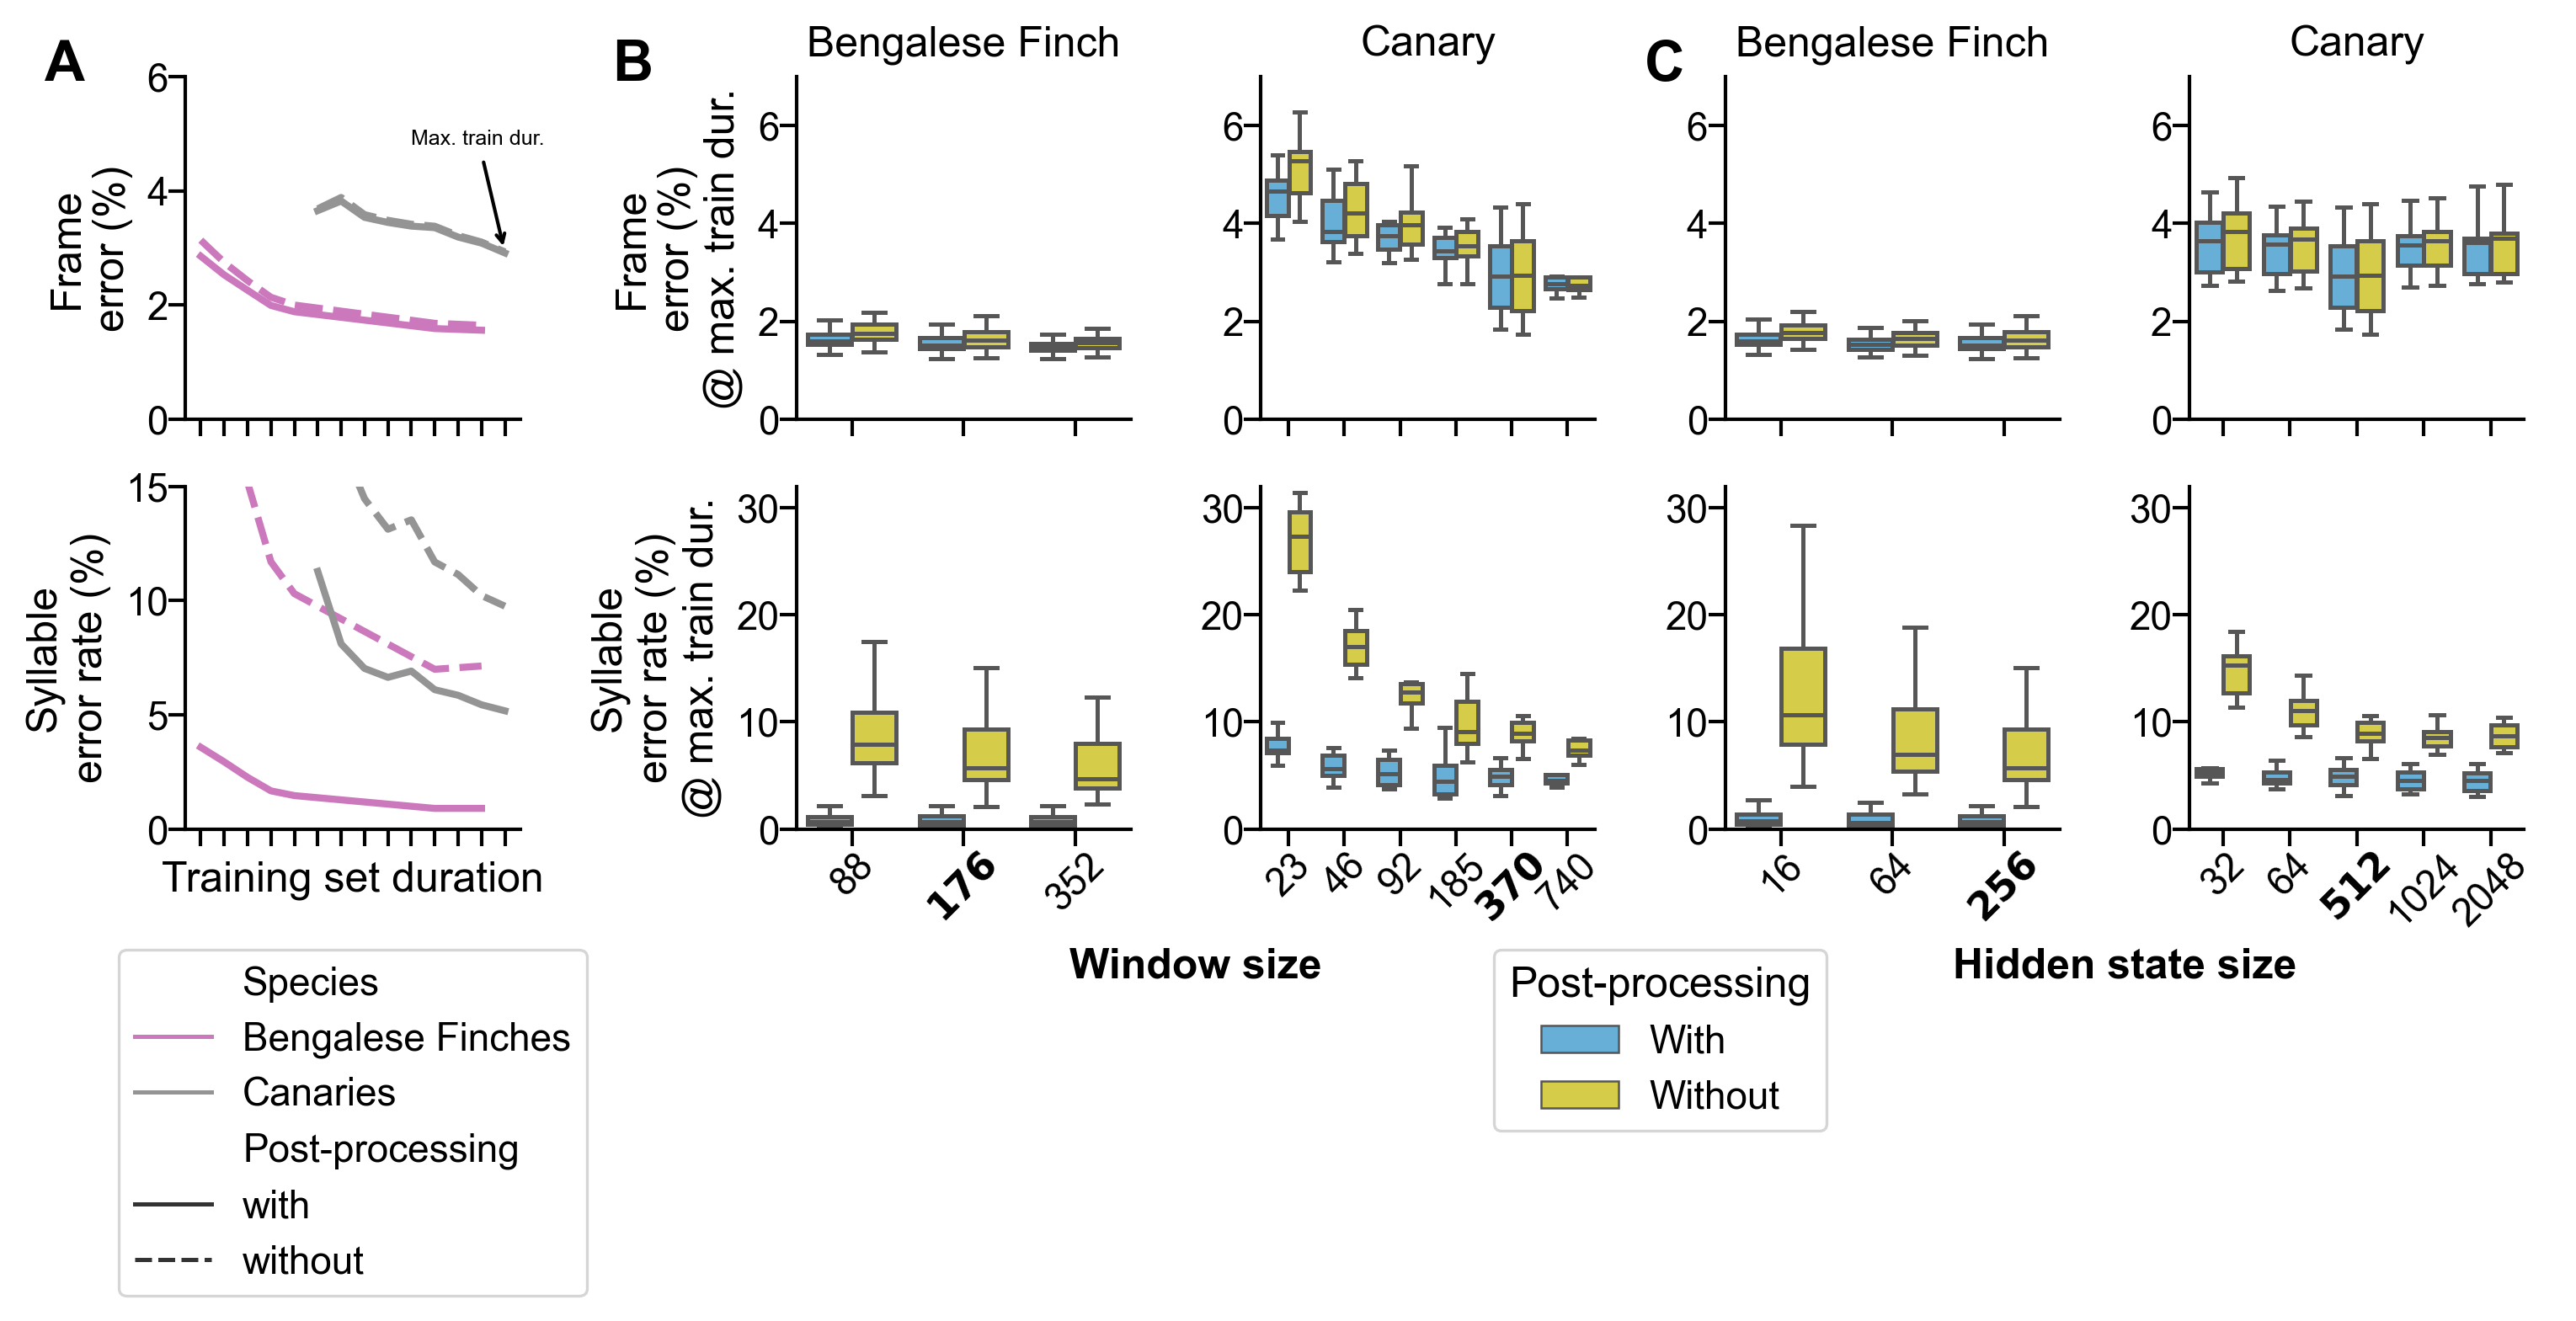

In [53]:
sns.set_context("paper", font_scale=1.25)

# ---- set-up
FIGSIZE = (10, 5)
DPI = 300

NROWS = 2  # frame error rate, syllable error rate
NCOLS = 5  # both species, Window Size(BF + Can), Hidden State Size(BF + Can)

fig = plt.figure(
    figsize=FIGSIZE,
    dpi=DPI,
    constrained_layout=True,
)

fig.set_constrained_layout_pads(
    w_pad=1/DPI,
    h_pad=1/DPI,
    hspace=0.01, 
    wspace=0.01
)

gs = fig.add_gridspec(
    NROWS,
    NCOLS,
)

ax_arr = []
for row in range(NROWS):
    for col in range(NCOLS):
        ax = fig.add_subplot(gs[row, col])
        ax_arr.append(ax)

ax_arr = np.array(ax_arr).reshape(NROWS, NCOLS)

for ax_ in ax_arr.flatten():
    # too lazy to write out rc config
    ax_.tick_params(pad=0.1)

big_gs = fig.add_gridspec(
    1,
    NCOLS,
)

big_ax_arr = []  # used to add titles, legends
BIG_AX_COL_STARTSTOP = (
    (0, 1),
    (1, 3),
    (3, 5),
)

for col_startstop in BIG_AX_COL_STARTSTOP:
    start_col, stop_col = col_startstop[0],  col_startstop[1]
    big_ax = fig.add_subplot(gs[:, start_col: stop_col], 
                            frameon=False
                            )
    big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    big_ax.grid(False)
    big_ax_arr.append(big_ax)

big_ax_arr = np.array(big_ax_arr)

# one last axis that we use for legend on all boxplots
biggest_ax = fig.add_subplot(gs[:, 1:], frameon=False)
biggest_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
biggest_ax.grid(False)

# ---- actually call the plotting functions
plot_first_col(ax_arr[:,0], big_ax_arr[0])

plot_other_cols(
    ax_arr[:, 1:],
    big_ax_arr[1:],
    biggest_ax
)

# ---- clean-up: panel letters, despine, etc.
labelpads = (2, 10)
panel_labels = ['A', 'B', 'C']
textxys = [
    (-0.3, 1.05),
    (-0.18, 1.05),
    (-0.05, 1.05),
]
for panel_label, textxy, big_ax in zip(panel_labels, textxys, big_ax_arr):
    x, y = textxy
    big_ax.text(x, y, panel_label, transform=big_ax.transAxes,
                fontsize=16, fontweight='bold', va='top', ha='right')

for ax in ax_arr.flatten():
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)

    
for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'effect-of-post-processing-and-hyperparams.{ext}',
        bbox_inches='tight',
    )